In [1]:
import pandas as pd, numpy as np, os
pd.options.mode.chained_assignment = None  # default='warn'
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime
from scipy.signal import find_peaks
from sklearn.manifold import TSNE

In [2]:
def remove_unknown_unavailable(data_path):
    df = pd.read_csv(data_path)
    unwanted_values = ['unavailable', 'unknown']
    df.replace(unwanted_values, np.nan, inplace=True)
    df_cleaned = df.dropna().copy()
    
    for i in reversed(list(df_cleaned.index)[1:]):
        # Compare the current row's sensor status with the previous row's sensor status
        if df_cleaned.loc[i].sensor_status == df_cleaned.iloc[df_cleaned.index.get_loc(i)-1].sensor_status:
            # Drop the current row if the statuses match
            df_cleaned.drop([i], inplace=True)
            
    np_array = np.array(df_cleaned, dtype='object')
    return df_cleaned, np_array

def get_available_months_years(np_array, column_number_with_time = 2):
    timestamps = np_array[:, column_number_with_time].astype(int)
    datetime_values = [datetime.fromtimestamp(ts / 1000) for ts in timestamps]
    dates = pd.to_datetime(datetime_values)
    periods = dates.to_period('M')
    unique_periods = np.unique(periods)
    return unique_periods

def extract_monthly_data(np_array, target_month = '2024-03'):
    df = pd.DataFrame(np_array, columns=['sensor_id', 'value', 'timestamp', 'subject_id'])
    df['timestamp'] = pd.to_datetime(df['timestamp'].astype(int), unit='ms')
    target_period = pd.Period(target_month, freq='M')
    df.set_index('timestamp', inplace=True)
    filtered_df = df[df.index.to_period('M') == target_period]
    indices = filtered_df.index
    filtered_np_array = filtered_df.reset_index().values
    return filtered_df, indices, filtered_np_array

def filter_on_off_consecutive(df):
    valid_indices = []
    for i in range(len(df) - 1):
        if df.loc[i, 'sensor_status'] == 'on' and df.loc[i + 1, 'sensor_status'] == 'off':
            valid_indices.append(i)
            valid_indices.append(i + 1)

    filtered_df = df.iloc[valid_indices]

    return filtered_df

def process_sensor_data(df):
    unique_statuses = df['sensor_status'].unique()
    valid_statuses = {'on', 'off'}
    
    if not set(unique_statuses).issubset(valid_statuses):
        # If there are other statuses present, return the original DataFrame
        print("Sensor status contains values other than 'on' and 'off'. Returning original DataFrame.")
        df['ts'] = pd.to_datetime(df['ts'], unit='ms')
        df['ts'] = df['ts'].dt.strftime('%Y-%m-%d %H:%M:%S.%f')
        return df
    # Check if the first row's sensor_status is 'off', and remove it if true because I want to start my analysis from ON
    if df.iloc[0]['sensor_status'] == 'off':
        df = df.iloc[1:].reset_index(drop=True)

    # Create masks for filtering 'on' and 'off' statuses
    mask_on = df['sensor_status'] == 'on'
    mask_off = df['sensor_status'] == 'off'

    # Separate DataFrames for 'on' and 'off' statuses
    df_on = df[mask_on].copy()
    df_off = df[mask_off].copy()

    # Rename timestamp columns
    df_on.rename(columns={'ts': 'ts_on'}, inplace=True)
    df_off.rename(columns={'ts': 'ts_off'}, inplace=True)

    # Reset index for merging
    df_on.reset_index(drop=True, inplace=True)
    df_off.reset_index(drop=True, inplace=True)

    # concatenate 'on' and 'off' DataFrames based on index
    df_conc = pd.merge(df_on, df_off[['ts_off']], left_index=True, right_index=True)

    # Calculate duration
    df_conc['duration_ms'] = df_conc['ts_off'] - df_conc['ts_on']

    # Convert timestamps to datetime
    df_conc['ts_on'] = pd.to_datetime(df_conc['ts_on'], unit='ms')
    df_conc['ts_off'] = pd.to_datetime(df_conc['ts_off'], unit='ms')
    
    # Reorder columns
    df_conc = df_conc[['sensor_id', 'subject_id', 'sensor_status', 'ts_on', 'ts_off', 'duration_ms']]
    
    return df_conc

def time_current_off_and_next_on(df):
    results = []
    for i in range(len(df)-1):
        ts_off = df.loc[i, 'ts_off']
        next_ts_on = df.loc[i + 1, 'ts_on']
        results.append({'ts_off': ts_off, 'next_ts_on': next_ts_on, 'difference': np.abs(next_ts_on - ts_off)})
    return results

def detect_peaks(df, value_col, prominence_value):
    peaks, properties = find_peaks(df[value_col], prominence=prominence_value)
    # print(f"Number of peaks found: {len(peaks)}")

    # peak_indicator = np.zeros(len(df), dtype=int)
    # peak_indicator[peaks] = 1

    peak_indicator = ['off'] * len(df)
    for peak in peaks:
        if peak < len(peak_indicator):
            peak_indicator[peak] = 'on'
    df['peak_detected'] = peak_indicator

    return peaks,df

def plot_data_with_peaks(df, time_col, value_col, peaks):
    df[time_col] = pd.to_datetime(df[time_col], unit='ms')
    df_peaks = df.iloc[peaks]    
    fig = px.line(df, x=time_col, y=value_col, title='Data with Peaks')
    fig.add_trace(
        go.Scatter(
            x=df_peaks[time_col],
            y=df_peaks[value_col],
            mode='markers',
            name='Peaks',
            marker=dict(color='red', size=10, symbol='x')
        )
    )
    fig.update_layout(
        xaxis_title='Timestamp',
        yaxis_title='Value',
        legend_title='Legend',
        template='plotly_white'
    )
    fig.update_yaxes(range=[df[value_col].min() - 1, df[value_col].max() + 1])
    fig.show()


def filter_sensors_by_window(df, start_time, end_time):
    # Convert 'ts_on' and 'ts_off' to datetime if they aren't already
    df['ts_on'] = pd.to_datetime(df['ts_on'])
    df['ts_off'] = pd.to_datetime(df['ts_off'])
    
    # Convert start_time and end_time to datetime
    start_time = pd.to_datetime(start_time)
    end_time = pd.to_datetime(end_time)
    
    # Filter rows where the sensor was active in the window
    active_sensors = df[((df['ts_on'] <= end_time) & (df['ts_off'] >= start_time))]
    
    return active_sensors

def filter_data_for_date(df, date_str):
    date = pd.to_datetime(date_str)
    filtered_df = df[(df['ts_on'].dt.date == date.date()) | (df['ts_off'].dt.date == date.date())]
    # filtered_df = df.loc[(df['ts_on'].dt.date == date) | (df['ts_off'].dt.date == date)]

    if filtered_df.empty:
        # print(f"No data found for the date: {date_str}")
        return filtered_df
    else:
        return filtered_df
    
def prepare_plot_data(date_specific_data):
    plot_data = []
    
    for entry in date_specific_data:
        sensor_name = entry['sensor']
        sensor_data = entry['data']
        
        if not sensor_data.empty:
            # Extracting the active periods
            for index, row in sensor_data.iterrows():
                plot_data.append({
                    'sensor': sensor_name,
                    'start_time': row['ts_on'],
                    'end_time': row['ts_off']
                })
    
    return pd.DataFrame(plot_data)

def plot_tsne(sample_size, data):
    # Aggregate data into samples
    aggregated_data = []
    for i in range(0, len(data), sample_size):
        sample = data[i:i+sample_size]
        if len(sample) == sample_size:
            aggregated_data.append(sample['sensor_status'].values)
    aggregated_data = np.array(aggregated_data)
    
    # Apply t-SNE
    tsne = TSNE(n_components=2, perplexity=5, random_state=0)
    tsne_results = tsne.fit_transform(aggregated_data)
    
    # Plot the t-SNE results
    plt.figure(figsize=(12, 8))
    plt.scatter(tsne_results[:, 0], tsne_results[:, 1], cmap='viridis', alpha=0.6)
    plt.colorbar(label='Sensor Status')
    plt.xlabel('t-SNE Feature 1')
    plt.ylabel('t-SNE Feature 2')
    plt.title(f't-SNE Plot with Sample Size {sample_size}')
    plt.show()

def remove_unknown_unavailable_v2(df):
    unwanted_values = ['unavailable', 'unknown']
    df.replace(unwanted_values, np.nan, inplace=True)
    df_cleaned = df.dropna().copy()
    
    for i in reversed(list(df_cleaned.index)[1:]):
        # Compare the current row's sensor status with the previous row's sensor status
        if df_cleaned.loc[i].sensor_status == df_cleaned.iloc[df_cleaned.index.get_loc(i)-1].sensor_status:
            # Drop the current row if the statuses match
            df_cleaned.drop([i], inplace=True)
            
    np_array = np.array(df_cleaned, dtype='object')
    return df_cleaned, np_array

In [ ]:
# data_path = '/home/hubble/work/serenade/data/subject_3/environmentals/Stove_Hum_Temp_temp.csv'
# cleaned_df, cleaned_array = remove_unknown_unavailable(data_path)
# available_months = get_available_months_years(cleaned_array, column_number_with_time = 2)
# target_month = '2024-03'
# df_month,indices, array_month = extract_monthly_data(cleaned_array, target_month)
# timestamps = array_month[:, 0]
# values = array_month[:, 2].astype(float)

# Prepare the clean data <sensor_name and dataframe pair>

In [4]:
path = '/home/hubble/work/serenade/data/subject_3/environmentals/' ## Subject 3
files = sorted(os.listdir(path))
unwanted_values = ['unavailable', 'unknown']
skip_substrings = ['event', 'HousejkjlEntrance']
cleaned_data = []
for i in range(len(files)):
    file_name = files[i]
    sensor_df = pd.read_csv(os.path.join(path, file_name))
    sensor_df.replace(unwanted_values, np.nan, inplace=True)
    df_cleaned = sensor_df.dropna().copy()
    dtyp = sensor_df['sensor_status'].dtype
    
    if dtyp == 'float64':
        if any(substring in file_name for substring in skip_substrings):
            print(i, '\t', file_name, '--XXXXX--')
            continue
        else:
            sensor_df = sensor_df.dropna(subset=['ts'])
            sensor_df = sensor_df[~sensor_df['sensor_status'].isin(['unavailable', 'unknown'])]
            sensor_df['sensor_status'] = pd.to_numeric(sensor_df['sensor_status'], errors='coerce')
            peaks, df_shower_humidity = detect_peaks(sensor_df, 'sensor_status', prominence_value = 2)
            sensor_df = sensor_df.rename(columns={'sensor_status': 'sensor_values', 'peak_detected': 'sensor_status'})
            print(i, '\t', file_name)
            # plot_data_with_peaks(sensor_df, 'ts', 'sensor_values', peaks)
            filtered_df = filter_on_off_consecutive(sensor_df)
            filtered_df = filtered_df.reset_index()
            filtered_df = process_sensor_data(filtered_df)
            cleaned_data.append({'sensor':file_name, 'filtered_df':filtered_df, 'sensor_df':sensor_df})
    else:

        if any(substring in file_name for substring in skip_substrings):
            print(i, '\t', file_name, '--XXXXX--')
            continue
        
        else:
            sensor_df, _ = remove_unknown_unavailable(os.path.join(path,file_name))
            filtered_df = process_sensor_data(sensor_df)
            cleaned_data.append({'sensor':file_name, 'filtered_df':filtered_df, 'sensor_df':sensor_df})
            print(i, '\t', file_name)

0 	 CoffeMachine.csv
1 	 CoffeMachine_events.csv --XXXXX--
2 	 Dishes_Glasses.csv
3 	 FoodStorageKitchen.csv
4 	 FoodStorageLivingRoom.csv
5 	 Freezer.csv
6 	 HouseEntrance.csv
7 	 Medicines.csv
8 	 Microwave.csv
9 	 Microwave_events.csv --XXXXX--
10 	 MotionBedroom.csv
11 	 MotionKitchen.csv
12 	 MotionLivingRoomSofa.csv
13 	 MotionLivingRoomTablet.csv
14 	 MotionPrimaryBathroom.csv
15 	 MotionSecondaryBathroom.csv
16 	 PlugTvHall.csv
17 	 PlugTvHall_events.csv --XXXXX--
18 	 Printer.csv
19 	 Refrigerator.csv
20 	 Shower_Hum_Temp_humidity.csv
21 	 Shower_Hum_Temp_temp.csv
22 	 Stove_Hum_Temp_humidity.csv
23 	 Stove_Hum_Temp_temp.csv
24 	 printer_events.csv --XXXXX--


In [4]:
## Code in this cell, is used to prepare the input for the problem "how many times did the subject go out of the home?"
data_path = '/home/hubble/work/serenade/data/subject_3/environmentals/HouseEntrance.csv'
df_cleaned, arr_cleaned = remove_unknown_unavailable(data_path)
df_processed = process_sensor_data(df_cleaned)
results = time_current_off_and_next_on(df_processed)
print(type(results))

<class 'list'>


In [5]:
results

[{'ts_off': Timestamp('2023-09-25 11:40:09.375000'),
  'next_ts_on': Timestamp('2023-09-25 11:47:21.478000'),
  'difference': Timedelta('0 days 00:07:12.103000')},
 {'ts_off': Timestamp('2023-09-25 11:47:27.901000'),
  'next_ts_on': Timestamp('2023-09-25 11:56:59.998000'),
  'difference': Timedelta('0 days 00:09:32.097000')},
 {'ts_off': Timestamp('2023-09-25 11:57:05.648000'),
  'next_ts_on': Timestamp('2023-09-25 12:57:53.875000'),
  'difference': Timedelta('0 days 01:00:48.227000')},
 {'ts_off': Timestamp('2023-09-25 12:58:00.813000'),
  'next_ts_on': Timestamp('2023-09-25 13:07:58.134000'),
  'difference': Timedelta('0 days 00:09:57.321000')},
 {'ts_off': Timestamp('2023-09-25 13:08:40.649000'),
  'next_ts_on': Timestamp('2023-09-25 14:40:31.118000'),
  'difference': Timedelta('0 days 01:31:50.469000')},
 {'ts_off': Timestamp('2023-09-25 14:40:38.863000'),
  'next_ts_on': Timestamp('2023-09-25 16:06:28.598000'),
  'difference': Timedelta('0 days 01:25:49.735000')},
 {'ts_off': Time

In [ ]:
## DO NOT RUN, IT TAKES A LONG TIME
## The following code check given a time window, if any of the sensors was activated in the house, If yes, the subject was present in the house, else, the subject went outside
for i in range(len(results)):
    query_window = results[i]
    ws, we = query_window['ts_off'], query_window['next_ts_on']
    print(ws,we)
    all_empty = True
    for j in range(len(cleaned_data)):
        df_in_question = cleaned_data[j]['filtered_df']
        if cleaned_data[j]['sensor'] == 'HouseEntrance.csv':
            continue
        a_s = filter_sensors_by_window(df_in_question, ws, we)
        if not a_s.empty:
            all_empty = False

    if all_empty:
        print(f"All a_s are empty for i = {i}, ws = {ws}, we = {we}")

# Extract data for specific date

In [5]:
specific_date = '2023-09-30'
date_specific_data = []
for i in range(len(cleaned_data)):
    sensor_name = cleaned_data[i]['sensor']
    print('---------',i,'----------', sensor_name)
    sensor_data = cleaned_data[i]['filtered_df']
    filtered_data = filter_data_for_date(sensor_data, specific_date)
    date_specific_data.append({'sensor':sensor_name, 'data': filtered_data})
    
plot_data = prepare_plot_data(date_specific_data)

--------- 0 ---------- CoffeMachine.csv
--------- 1 ---------- Dishes_Glasses.csv
--------- 2 ---------- FoodStorageKitchen.csv
--------- 3 ---------- FoodStorageLivingRoom.csv
--------- 4 ---------- Freezer.csv
--------- 5 ---------- HouseEntrance.csv
--------- 6 ---------- Medicines.csv
--------- 7 ---------- Microwave.csv
--------- 8 ---------- MotionBedroom.csv
--------- 9 ---------- MotionKitchen.csv
--------- 10 ---------- MotionLivingRoomSofa.csv
--------- 11 ---------- MotionLivingRoomTablet.csv
--------- 12 ---------- MotionPrimaryBathroom.csv
--------- 13 ---------- MotionSecondaryBathroom.csv
--------- 14 ---------- PlugTvHall.csv
--------- 15 ---------- Printer.csv
--------- 16 ---------- Refrigerator.csv
--------- 17 ---------- Shower_Hum_Temp_humidity.csv
--------- 18 ---------- Shower_Hum_Temp_temp.csv
--------- 19 ---------- Stove_Hum_Temp_humidity.csv
--------- 20 ---------- Stove_Hum_Temp_temp.csv


# Define color for each sensor

In [7]:
# Define the color map
color_map = {
    'Shower_Hum_Temp_humidity.csv': 'red',
    'Medicines.csv': 'blue',
    'MotionSecondaryBathroom.csv': 'green',
    'Refrigerator.csv': 'orange',
    'MotionBedroom.csv': 'purple',
    'Dishes_Glasses.csv': 'brown',
    'HouseEntrance.csv': 'pink',
    'Microwave.csv': 'gray',
    'CoffeMachine_events.csv': 'olive',
    'Stove_Hum_Temp_humidity.csv': 'cyan',
    'PlugTvHall.csv': 'magenta',
    'MotionPrimaryBathroom.csv': 'lime',
    'printer_events.csv': 'navy',
    'Printer.csv': 'teal',
    'MotionKitchen.csv': 'maroon',
    'MotionLivingRoomTablet.csv': 'darkgoldenrod',
    'Freezer.csv': 'black',
    'Stove_Hum_Temp_temp.csv': 'silver',
    'FoodStorageKitchen.csv': 'goldenrod',
    'Shower_Hum_Temp_temp.csv': 'coral',
    'FoodStorageLivingRoom.csv': 'aqua',
    'Microwave_events.csv': 'plum',
    'PlugTvHall_events.csv': 'orchid',
    'CoffeMachine.csv': 'tan',
    'MotionLivingRoomSofa.csv': 'khaki'
}

# Plot the graph for a specific date

In [8]:

df = pd.DataFrame(plot_data)
df['start_time'] = pd.to_datetime(df['start_time'])
df['end_time'] = pd.to_datetime(df['end_time'])

df['start_time_of_day'] = df['start_time'].dt.time # I will not use it
df['end_time_of_day'] = df['end_time'].dt.time # I will not use it because a sensor activation may go beyond a day, so date changes, so it is better to keep only start-time

# Sort the DataFrame by both start_time and end_time
df = df.sort_values(by=['start_time', 'end_time'])

# Initialize the plot
fig = go.Figure()

# Add points to the plot
for _, row in df.iterrows():
    sensor = row['sensor']
    color = color_map.get(sensor, 'black')
    # Plot the start and end time points
    fig.add_trace(go.Scatter(
        x=[row['start_time'], row['end_time']],
        y=[row['sensor'], row['sensor']],
        mode='markers+lines',
        marker=dict(size=8, color=color),
        line=dict(width=1, color=color),
        name=row['sensor'],
        showlegend=False
    ))

# Update layout
fig.update_layout(
    title="Sensor Activity Over Time of Day",
    xaxis_title='Time of Day',
    yaxis_title='Sensor',
    xaxis=dict(tickformat='%H:%M:%S', title='Time of Day'),
    yaxis=dict(title='Sensor', categoryorder='total ascending'),
    showlegend=False
)

# Show plot
fig.show()

# Subject 1 data for temperature sensor in bathroom

In [ ]:
path = '/home/hubble/work/serenade/data/subject_1/environmentals/Shower_Hum_Temp_temp.csv'
df_shower_humidity = pd.read_csv(path)
df_shower_humidity['ts'] = pd.to_datetime(df_shower_humidity['ts'], unit='ms')

df_shower_humidity = df_shower_humidity.dropna(subset=['ts'])
df_shower_humidity = df_shower_humidity[~df_shower_humidity['sensor_status'].isin(['unavailable', 'unknown'])]
df_shower_humidity['sensor_status'] = pd.to_numeric(df_shower_humidity['sensor_status'], errors='coerce')

peaks, df_shower_humidity = detect_peaks(df_shower_humidity, 'sensor_status', prominence_value = 1)
# print(peaks)
# plot_data_with_peaks(df_shower_humidity, 'ts', 'sensor_status', peaks)

# Subject 2 data for temperature sensor in bathroom

In [ ]:
path = '/home/hubble/work/serenade/data/subject_2/environmentals/Hum_Temp_Bath_temp.csv'
df_shower_humidity = pd.read_csv(path)
df_shower_humidity['ts'] = pd.to_datetime(df_shower_humidity['ts'], unit='ms')

df_shower_humidity = df_shower_humidity.dropna(subset=['ts'])
df_shower_humidity = df_shower_humidity[~df_shower_humidity['sensor_status'].isin(['unavailable', 'unknown'])]
df_shower_humidity['sensor_status'] = pd.to_numeric(df_shower_humidity['sensor_status'], errors='coerce')

peaks, df_shower_humidity = detect_peaks(df_shower_humidity, 'sensor_status', prominence_value = 0.8)
# plot_data_with_peaks(df_shower_humidity, 'ts', 'sensor_status', peaks)

# Subject 3 data for humidity from stove

In [ ]:
path = '/home/hubble/work/serenade/data/subject_3/environmentals/Stove_Hum_Temp_humidity.csv'
df_shower_humidity = pd.read_csv(path)
df_shower_humidity['ts'] = pd.to_datetime(df_shower_humidity['ts'], unit='ms')

df_shower_humidity = df_shower_humidity.dropna(subset=['ts'])
df_shower_humidity = df_shower_humidity[~df_shower_humidity['sensor_status'].isin(['unavailable', 'unknown'])]
df_shower_humidity['sensor_status'] = pd.to_numeric(df_shower_humidity['sensor_status'], errors='coerce')

peaks, df_shower_humidity = detect_peaks(df_shower_humidity, 'sensor_status', prominence_value = 3)
df_shower_humidity = df_shower_humidity.rename(columns={'sensor_status': 'sensor_values', 'peak_detected': 'sensor_status'})
# plot_data_with_peaks(df_shower_humidity, 'ts', 'sensor_values', peaks)

filtered_df = filter_on_off_consecutive(df_shower_humidity)
filtered_df = filtered_df.reset_index()
filtered_df = process_sensor_data(filtered_df)

In [ ]:
# Step 1: Read the file HomeEntrance.csv
# Step 2: Identify the current door close time and the next door open time
# Step 3: If no sensor is activated within the window obtained from Step 2, the person is 'probably outside the home'
# Note: The time duration between the current door close and the next door open event is crucial. If the duration is very short, it is possible that the subject opened the door just to attend to a visitor.

# Names of the sensors installed for subject 3

In [9]:
for i in range(len(cleaned_data)):
    sensor_name = cleaned_data[i]['sensor']
    print('---------',i,'----------', sensor_name)

--------- 0 ---------- CoffeMachine.csv
--------- 1 ---------- Dishes_Glasses.csv
--------- 2 ---------- FoodStorageKitchen.csv
--------- 3 ---------- FoodStorageLivingRoom.csv
--------- 4 ---------- Freezer.csv
--------- 5 ---------- HouseEntrance.csv
--------- 6 ---------- Medicines.csv
--------- 7 ---------- Microwave.csv
--------- 8 ---------- MotionBedroom.csv
--------- 9 ---------- MotionKitchen.csv
--------- 10 ---------- MotionLivingRoomSofa.csv
--------- 11 ---------- MotionLivingRoomTablet.csv
--------- 12 ---------- MotionPrimaryBathroom.csv
--------- 13 ---------- MotionSecondaryBathroom.csv
--------- 14 ---------- PlugTvHall.csv
--------- 15 ---------- Printer.csv
--------- 16 ---------- Refrigerator.csv
--------- 17 ---------- Shower_Hum_Temp_humidity.csv
--------- 18 ---------- Shower_Hum_Temp_temp.csv
--------- 19 ---------- Stove_Hum_Temp_humidity.csv
--------- 20 ---------- Stove_Hum_Temp_temp.csv


# Howmany times a device was interacted by the subject on a given date


In [14]:
## Howmany times a device was interacted by the subject on a given date
## When there is no food preparation in the house
## Pick a date and count the out-events

house_entrance_df = cleaned_data[5] ## maindoor of the house
temp_df = house_entrance_df['filtered_df'].copy()
## Extract the unique dates
temp_df['date'] = temp_df['ts_on'].dt.date
dates = temp_df['date'].unique()

for i in range(3):#len(dates)):
    date = dates[i]
    print('------->',date)
    first_rows = temp_df.groupby('date').first().reset_index() # Pick the first row of each unique date
    last_rows = temp_df.groupby('date').last().reset_index() # Pick the last row of each unique date
    # select the date specific data
    first_row = first_rows[first_rows['date'] == date] 
    last_row = last_rows[last_rows['date'] == date]
    current_off_time = first_row['ts_off'].iloc[0]
    next_on_time = last_row['ts_on'].iloc[0]
    time_difference = next_on_time - current_off_time
    sensor_and_activation = []
    for j in range(len(cleaned_data)):
        if j == -5:
            continue
        sensor = cleaned_data[j]['sensor']
        current_data = cleaned_data[j]['filtered_df']
        if current_off_time.date() == next_on_time.date():
            # If date is same for both values of window
            filtered_data = filter_data_for_date(current_data, current_off_time.date())
        else:
            # If date is different for both values of window
            # In this case concat the data for both dates
            filtered_data_current_date = filter_data_for_date(current_data, current_off_time.date())
            filtered_data_next_date = filter_data_for_date(current_data, next_on_time.date())
            filtered_data = pd.concat([filtered_data_current_date, filtered_data_next_date], ignore_index=True)
        # print(sensor, len(filtered_data))
        sensor_and_activation.append({'senosr':sensor, 'activation_count':len(filtered_data)})

    # Extract sensor names and their activation counts and plot it
    sensors = [item['senosr'] for item in sensor_and_activation]
    activation_counts = [item['activation_count'] for item in sensor_and_activation]

    fig = go.Figure(data=[go.Bar(x=sensors, y=activation_counts)])
    fig.update_layout(
        title='Sensor Activation Counts',
        xaxis_title='Sensors',
        yaxis_title='Activation Count',
        xaxis_tickangle=-90,
        template='plotly_white',
        xaxis=dict(
            tickfont=dict(size=14),  # Font size for x-axis ticks
            titlefont=dict(size=18)  # Font size for x-axis title
        ),
        yaxis=dict(
            tickfont=dict(size=18),  # Font size for y-axis ticks
            titlefont=dict(size=18)  # Font size for y-axis title
        )
    )

    fig.add_annotation(
    xref='paper', yref='paper',  # Use paper coordinates (relative to the plotting area)
    x=0.5, y=1.5,  # Position the annotation
    text=f"Date: {date}",  # Text to display
    showarrow=False,  # No arrow for the annotation
    font=dict(size=18, color="black"),
    align="center"
)
    fig.show()



-------> 2023-09-25


-------> 2023-09-26


-------> 2023-09-27


# howmany times a subject was outside or probably outside of house?


In [13]:

house_entrance_df = cleaned_data[5]
for i in range(1,len(house_entrance_df['filtered_df'])):
    current_off_time = house_entrance_df['filtered_df'].iloc[i-1]['ts_off']
    next_on_time = house_entrance_df['filtered_df'].iloc[i]['ts_on']
    time_difference = next_on_time - current_off_time
    # print_statement = f"The following sensors were activated between {next_on_time}-{current_off_time} = {time_difference}------>"
    # print(print_statement)

    activated_sensors = []
    for j in range(len(cleaned_data)):
        if j == 5:
            continue        
        sensor = cleaned_data[j]['sensor']
        current_data = cleaned_data[j]['filtered_df']
        if current_off_time.date() == next_on_time.date():
            # If date is same for both values of window
            filtered_data = filter_data_for_date(current_data, current_off_time.date())
        else:
            # If date is different for both values of window
            # In this case concat the data for both dates
            filtered_data_current_date = filter_data_for_date(current_data, current_off_time.date())
            filtered_data_next_date = filter_data_for_date(current_data, next_on_time.date())
            filtered_data = pd.concat([filtered_data_current_date, filtered_data_next_date], ignore_index=True)

        filtered = filter_sensors_by_window(filtered_data, current_off_time, next_on_time)
        if not filtered.empty:
            activated_sensors.append({'sensor':sensor, 'relevent_row':filtered})#,'filtered_data':filtered_data})

    if len(activated_sensors) == 0:
        print_statement = f"No sensors were activated between {next_on_time}-{current_off_time} = {time_difference}------>"
        print(print_statement)   
    

No sensors were activated between 2023-09-27 12:59:32.141000-2023-09-27 12:59:20.207000 = 0 days 00:00:11.934000------>
No sensors were activated between 2023-09-27 17:22:31.826000-2023-09-27 16:30:52.990000 = 0 days 00:51:38.836000------>
No sensors were activated between 2023-09-28 06:41:36.640000-2023-09-28 06:41:19.887000 = 0 days 00:00:16.753000------>
No sensors were activated between 2023-09-28 08:43:20.752000-2023-09-28 08:43:18.253000 = 0 days 00:00:02.499000------>
No sensors were activated between 2023-09-29 11:13:21.518000-2023-09-29 11:12:47.860000 = 0 days 00:00:33.658000------>
No sensors were activated between 2023-09-30 10:34:28.003000-2023-09-30 10:33:56.661000 = 0 days 00:00:31.342000------>
No sensors were activated between 2023-10-03 09:52:47.326000-2023-10-03 09:45:44.966000 = 0 days 00:07:02.360000------>
No sensors were activated between 2023-10-04 21:53:08.606000-2023-10-04 21:53:05.939000 = 0 days 00:00:02.667000------>
No sensors were activated between 2023-1

# Format to show activation of different sensors in a given window

In [14]:
## Load the main door data
house_entrance_df = cleaned_data[5]
## Make a 10 minutes window
ws = pd.to_datetime('2023-09-25 12:49:18.709000')
we = ws + pd.Timedelta(minutes=10)

## Make a vector of 0 and 1 when sensor was active in each one minute out of 10 minute
a = []
for i in range(len(cleaned_data)):
    sensor_name = cleaned_data[i]['sensor']
    sensor_df = cleaned_data[i]['filtered_df']
    print(sensor_name)#,'\n', sensor_df.head())
    subset_df = sensor_df[(sensor_df['ts_on'] <= we) & (sensor_df['ts_off'] >= ws)]

    time_series = pd.date_range(start=ws, end=we, freq='T')
    vector = np.zeros(len(time_series))

    for j, current_time in enumerate(time_series):
        for _, row in subset_df.iterrows():
            if row['ts_on'] <= current_time < row['ts_off']:
                vector[j] = 1
                break
    
    a.append({sensor_name:vector})

CoffeMachine.csv
Dishes_Glasses.csv
FoodStorageKitchen.csv
FoodStorageLivingRoom.csv
Freezer.csv
HouseEntrance.csv
Medicines.csv
Microwave.csv
MotionBedroom.csv
MotionKitchen.csv
MotionLivingRoomSofa.csv
MotionLivingRoomTablet.csv
MotionPrimaryBathroom.csv
MotionSecondaryBathroom.csv
PlugTvHall.csv
Printer.csv
Refrigerator.csv
Shower_Hum_Temp_humidity.csv
Shower_Hum_Temp_temp.csv
Stove_Hum_Temp_humidity.csv
Stove_Hum_Temp_temp.csv


# List of sensors across all the subject

In [15]:
sensor_files = [
    "CoffeMachine.csv",
    "CoffeMachine_events.csv",
    "Cookware.csv",
    "Dishes.csv",
    "Dishes_Glasses.csv",
    "Dishes_Silverware.csv",
    "FoodStorage.csv",
    "FoodStorageKitchen.csv",
    "FoodStorageLivingRoom.csv",
    "Freezer.csv",
    "HouseEntrance.csv",
    "Hum_Temp_Bath_humidity.csv",
    "Hum_Temp_Bath_temp.csv",
    "Hum_Temp_Stove_humidity.csv",
    "Hum_Temp_Stove_temp.csv",
    "Medicines.csv",
    "Microwave.csv",
    "Microwave_events.csv",
    "MotionBathroom.csv",
    "MotionBedroom.csv",
    "MotionDiningTable.csv",
    "MotionGuestRoom.csv",
    "MotionKitchen.csv",
    "MotionLivingRoomSofa.csv",
    "MotionLivingRoomTablet.csv",
    "MotionLivingroom.csv",
    "MotionOffice.csv",
    "MotionOtherRoom.csv",
    "MotionOtherroom.csv",
    "MotionPrimaryBathroom.csv",
    "MotionSecondaryBathroom.csv",
    "PlugTvHall.csv",
    "PlugTvHall_events.csv",
    "PlugTvKitchen.csv",
    "Printer.csv",
    "Refrigerator.csv",
    "Shower_Hum_Temp_humidity.csv",
    "Shower_Hum_Temp_temp.csv",
    "Silverware.csv",
    "Stove_Hum_Temp_humidity.csv",
    "Stove_Hum_Temp_temp.csv",
    "WashingMachine.csv",
    "printer_events.csv",
    "washingMachine_events.csv"
]
print(len(sensor_files))

44


# Prepare the cleaned data for all the subjects

In [16]:
data_path = '/home/hubble/work/serenade/data'
subjects = ['subject_1','subject_2','subject_3','subject_4','subject_5','subject_7','subject_8']
unwanted_values = ['unavailable', 'unknown']
skip_substrings = ['event', 'HousejkjlEntrance']

subject_data = []
for i  in range(len(subjects)):
    subject_i = subjects[i]
    subject_data_path = os.path.join(data_path,subject_i,'environmentals')
    print('--+'*20)
    print(subject_data_path)

    cleaned_data = []
    for j in range(len(sensor_files)):
        file_name = sensor_files[j]
        
        if any(substring in file_name for substring in skip_substrings):
            continue
        else:
            file_path = os.path.join(subject_data_path,file_name)
            try:
                sensor_df = pd.read_csv(file_path)
                sensor_df = sensor_df[~sensor_df['sensor_status'].isin(['unavailable', 'unknown'])]
                unique_values = set(sensor_df['sensor_status'].unique())
                contains_on = 'on' in unique_values
                contains_off = 'off' in unique_values

                if contains_on or contains_off:
                    pass
                else:
                    sensor_df['sensor_status'] = pd.to_numeric(sensor_df['sensor_status'], errors='coerce')

                data_type = sensor_df['sensor_status'].dtype

                if data_type == 'float64':
                    print(j, '\t', file_name, '\t', data_type)

                    sensor_df['sensor_status'] = pd.to_numeric(sensor_df['sensor_status'], errors='coerce')
                    peaks, df_shower_humidity = detect_peaks(sensor_df, 'sensor_status', prominence_value = 2)
                    sensor_df = sensor_df.rename(columns={'sensor_status': 'sensor_values', 'peak_detected': 'sensor_status'})
                    filtered_df = filter_on_off_consecutive(sensor_df)
                    filtered_df = filtered_df.reset_index()
                    filtered_df = process_sensor_data(filtered_df)
                    cleaned_data.append({'sensor':file_name, 'filtered_df':filtered_df, 'sensor_df':sensor_df})

                else:
                    print(j, '\t', file_name, '\t', data_type)
                    sensor_df, _ = remove_unknown_unavailable_v2(sensor_df)
                    filtered_df = process_sensor_data(sensor_df)
                    cleaned_data.append({'sensor':file_name, 'filtered_df':filtered_df, 'sensor_df':sensor_df})

            except FileNotFoundError:
                sensor_df = pd.DataFrame()
                cleaned_data.append({'sensor':file_name, 'filtered_df':pd.DataFrame(), 'sensor_df':pd.DataFrame()})
            except Exception as e:
                sensor_df = pd.DataFrame()
                cleaned_data.append({'sensor':file_name, 'filtered_df':pd.DataFrame(), 'sensor_df':pd.DataFrame()})
                    
    subject_data.append(cleaned_data)


--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+
/home/hubble/work/serenade/data/subject_1/environmentals
4 	 Dishes_Glasses.csv 	 object
6 	 FoodStorage.csv 	 object
9 	 Freezer.csv 	 object
10 	 HouseEntrance.csv 	 object
16 	 Microwave.csv 	 float64
18 	 MotionBathroom.csv 	 object
19 	 MotionBedroom.csv 	 object
22 	 MotionKitchen.csv 	 object
25 	 MotionLivingroom.csv 	 object
31 	 PlugTvHall.csv 	 float64
35 	 Refrigerator.csv 	 object
36 	 Shower_Hum_Temp_humidity.csv 	 float64
37 	 Shower_Hum_Temp_temp.csv 	 float64
38 	 Silverware.csv 	 object
41 	 WashingMachine.csv 	 float64
--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+
/home/hubble/work/serenade/data/subject_2/environmentals
5 	 Dishes_Silverware.csv 	 object
6 	 FoodStorage.csv 	 object
10 	 HouseEntrance.csv 	 object
11 	 Hum_Temp_Bath_humidity.csv 	 float64
12 	 Hum_Temp_Bath_temp.csv 	 float64
13 	 Hum_Temp_Stove_humidity.csv 	 float64
14 	 Hum_Temp_Stove_temp.csv 	 float64
15 	 Medicines.csv 

In [34]:
subject = subject_data[0]
print(subject[0])
sensor_name = subject[0]['sensor']
sensor_df = subject[0]['filtered_df']
print(sensor_name, sensor_df)

{'sensor': 'CoffeMachine.csv', 'filtered_df': Empty DataFrame
Columns: []
Index: [], 'sensor_df': Empty DataFrame
Columns: []
Index: []}
CoffeMachine.csv Empty DataFrame
Columns: []
Index: []


# Make window for all subjects

In [49]:
initial_ws = pd.to_datetime('2023-10-11 16:18:35.414')
window_duration = pd.Timedelta(minutes=15)
number_of_windows_per_subject = 3

# Iterate over each subject
subject_window = []
for sb in range(1):#len(subject_data)):
    subject = subject_data[sb]
    current_ws = initial_ws

    window_results = []
    wr = []
    c = 0
    for _ in range(number_of_windows_per_subject):
        we = current_ws + window_duration
        print(c)
        c = c + 1
        sr = []
        for sensor_data in subject:
            sensor_name = sensor_data['sensor']
            sensor_df = sensor_data['filtered_df']

            if sensor_df.empty:
                # If sensor_df is empty, append a vector of zeros
                time_series = pd.date_range(start=current_ws, end=we, freq='T')
                vector = np.ones(len(time_series)) * -99
                window_results.append({sensor_name: vector})
                wr.append(vector)
                # print(f"Sensor {sensor_name} has no data in window from {current_ws} to {we}")
                continue

            subset_df = sensor_df[(sensor_df['ts_on'] <= we) & (sensor_df['ts_off'] >= current_ws)]
            time_series = pd.date_range(start=current_ws, end=we, freq='T')
            vector = np.zeros(len(time_series))

            if not subset_df.empty:
                # Populate the vector with 1s where the sensor was active
                for j, current_time in enumerate(time_series):
                    if any((row['ts_on'] <= current_time < row['ts_off']) for _, row in subset_df.iterrows()):
                        vector[j] = 1
            else:
                pass
            wr.append(vector)
            window_results.append({sensor_name: vector})
        sr.append(wr)
        print(f"Window from {current_ws} to {we}:")
        for result in wr:
            print(result)

        current_ws = we + pd.Timedelta(seconds=1)

    subject_window.append(sr)
    print(f"Finished processing subject")


0
Window from 2023-10-11 16:18:35.414000 to 2023-10-11 16:33:35.414000:
[-99. -99. -99. -99. -99. -99. -99. -99. -99. -99. -99. -99. -99. -99.
 -99. -99.]
[-99. -99. -99. -99. -99. -99. -99. -99. -99. -99. -99. -99. -99. -99.
 -99. -99.]
[-99. -99. -99. -99. -99. -99. -99. -99. -99. -99. -99. -99. -99. -99.
 -99. -99.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[-99. -99. -99. -99. -99. -99. -99. -99. -99. -99. -99. -99. -99. -99.
 -99. -99.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[-99. -99. -99. -99. -99. -99. -99. -99. -99. -99. -99. -99. -99. -99.
 -99. -99.]
[-99. -99. -99. -99. -99. -99. -99. -99. -99. -99. -99. -99. -99. -99.
 -99. -99.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[-99. -99. -99. -99. -99. -99. -99. -99. -99. -99. -99. -99. -99. -99.
 -99. -99.]
[-99. -99. -99. -99. -99. -99. -99. -99. -99. -99. -99. -99. -99. -99.
 -99. -99.]
[-99. -99. -99. -99. -99. -99. -99. -99. -99. -99. -99. -99. -99

In [51]:
len(sr)

1

In [24]:
def plot_duration_distribution(on_off_diff):
    # Convert the list to a DataFrame
    df = pd.DataFrame(on_off_diff, columns=['end_time', 'start_time', 'duration'])
    
    # Ensure the time columns are in datetime format
    df['start_time'] = pd.to_datetime(df['start_time'])
    df['end_time'] = pd.to_datetime(df['end_time'])
    
    # Calculate the duration in seconds and minutes
    df['duration_seconds'] = (df['end_time'] - df['start_time']).dt.total_seconds()
    df['duration_minutes'] = df['duration_seconds'] / 60
    
    # Create bins of five minutes up to 120 minutes, and include one bin for > 2 hours
    bins = list(range(0, 120, 5)) + [float('inf')]
    labels = [f"{i}-{i+5} min" for i in range(0, 115, 5)] + [">120 min"]
    
    # Bin the data
    df['binned_duration'] = pd.cut(df['duration_minutes'], bins=bins, labels=labels, right=False)
    
    # Check for NaNs in the binned_duration
    if df['binned_duration'].isna().any():
        print("Some durations couldn't be binned. Please check the data.")
    
    # Count the number of occurrences in each bin
    bin_counts = df['binned_duration'].value_counts(sort=False).reset_index()
    bin_counts.columns = ['binned_duration', 'count']
    
    # Plot using plotly
    fig = px.bar(bin_counts, x='binned_duration', y='count', title='Distribution of Durations',
                 labels={'binned_duration': 'Duration Bins', 'count': 'Count'})
    fig.update_layout(xaxis_tickangle=-45)
    fig.show()

In [25]:
for sub in range(len(subject_data)):
    subject_i_data = subject_data[sub]

    house_entrance_df = subject_i_data[9]
    on_off_diff = []
    max_time_difference = pd.Timedelta(0)  # Initialize to zero timedelta
    count_on = 0
    count_off = 0
    for hed in range(1,len(house_entrance_df['filtered_df'])):
        # print('----------------',hed,'---------------------------')
        current_off_time = house_entrance_df['filtered_df'].iloc[hed-1]['ts_off']
        next_on_time = house_entrance_df['filtered_df'].iloc[hed]['ts_on']
        time_difference = next_on_time - current_off_time

        activated_sensors = []
        tempdf = []
        for sens in range(len(subject_i_data)):
            if sens == 9:
                continue
            sensor_name = subject_i_data[sens]['sensor']
            sensor_data = subject_i_data[sens]['filtered_df']
            
            if current_off_time.date() == next_on_time.date():
                # If date is same for both values of window
                filtered_data = filter_data_for_date(current_data, current_off_time.date())
            else:
                # If date is different for both values of window
                # In this case concat the data for both dates
                filtered_data_current_date = filter_data_for_date(current_data, current_off_time.date())
                filtered_data_next_date = filter_data_for_date(current_data, next_on_time.date())
                filtered_data = pd.concat([filtered_data_current_date, filtered_data_next_date], ignore_index=True)

            # activated_sensors.append({'sensor':sensor, 'filtered_data':filtered_data})
            filtered = filter_sensors_by_window(filtered_data, current_off_time, next_on_time)
            tempdf.append(filtered)
            if not filtered.empty:     
                activated_sensors.append({'sensor':sensor, 'relevent_row':filtered})
            else:
                pass

        
        if len(activated_sensors) == 0:
            count_off = count_off + 1
            on_off_diff.append([next_on_time, current_off_time, time_difference])
            # print_statement = f"{hed} No sensors were activated between {next_on_time}-{current_off_time} = {time_difference}------>"
        else: 
            count_on = count_on + 1
    plot_duration_distribution(on_off_diff)


In [93]:
on_off_diff

[]

In [128]:
for sub in range(5):#len(subject_data)):
    subject_i_data = subject_data[sub]
    house_entrance_df = subject_i_data[9]
    temp_df = house_entrance_df['filtered_df'].copy()
    temp_df['date'] = temp_df['ts_on'].dt.date
    dates = temp_df['date'].unique()
    print('-----------',sub)

    for dt in range(3): ## I do not want to print for each date
        date = dates[dt]
        print('------->',date)
        first_rows = temp_df.groupby('date').first().reset_index() # Pick the first row of each unique date
        last_rows = temp_df.groupby('date').last().reset_index() # Pick the last row of each unique date

        first_row = first_rows[first_rows['date'] == date] 
        last_row = last_rows[last_rows['date'] == date]
        current_off_time = first_row['ts_off'].iloc[0]
        next_on_time = last_row['ts_on'].iloc[0]
        time_difference = next_on_time - current_off_time
        sensor_and_activation = []

        for j in range(len(subject_i_data)):
            if j == -5:
                continue
            sensor = subject_i_data[j]['sensor']
            current_data = subject_i_data[j]['filtered_df']
            if len(current_data) > 0:
                if current_off_time.date() == next_on_time.date():
                    # If date is same for both values of window
                    filtered_data = filter_data_for_date(current_data, current_off_time.date())
                else:
                    # If date is different for both values of window
                    # In this case concat the data for both dates
                    filtered_data_current_date = filter_data_for_date(current_data, current_off_time.date())
                    filtered_data_next_date = filter_data_for_date(current_data, next_on_time.date())
                    filtered_data = pd.concat([filtered_data_current_date, filtered_data_next_date], ignore_index=True)
                # print(sensor, len(filtered_data))
                sensor_and_activation.append({'senosr':sensor, 'activation_count':len(filtered_data)})

        # Extract sensor names and their activation counts and plot it
        sensors = [item['senosr'] for item in sensor_and_activation]
        activation_counts = [item['activation_count'] for item in sensor_and_activation]

        fig = go.Figure(data=[go.Bar(x=sensors, y=activation_counts)])
        fig.update_layout(
            title='Sensor Activation Counts',
            xaxis_title='Sensors',
            yaxis_title='Activation Count',
            xaxis_tickangle=-90,
            template='plotly_white'
        )

        fig.add_annotation(
        xref='paper', yref='paper',  # Use paper coordinates (relative to the plotting area)
        x=0.5, y=1.5,  # Position the annotation
        text=f"Date: {date}",  # Text to display
        showarrow=False,  # No arrow for the annotation
        font=dict(size=14, color="black"),
        align="center"
    )
        fig.show()




[datetime.date(2023, 10, 11) datetime.date(2023, 10, 12)
 datetime.date(2023, 10, 13) datetime.date(2023, 10, 14)
 datetime.date(2023, 10, 15) datetime.date(2023, 10, 16)
 datetime.date(2023, 10, 17) datetime.date(2023, 10, 18)
 datetime.date(2023, 10, 19) datetime.date(2023, 10, 20)
 datetime.date(2023, 10, 21) datetime.date(2023, 10, 22)
 datetime.date(2023, 10, 23) datetime.date(2023, 10, 25)
 datetime.date(2023, 10, 26) datetime.date(2023, 10, 27)
 datetime.date(2023, 10, 28) datetime.date(2023, 10, 29)
 datetime.date(2023, 10, 30) datetime.date(2023, 10, 31)
 datetime.date(2023, 11, 1) datetime.date(2023, 11, 2)
 datetime.date(2023, 11, 3) datetime.date(2023, 11, 4)
 datetime.date(2023, 11, 5) datetime.date(2023, 11, 6)
 datetime.date(2023, 11, 7) datetime.date(2023, 11, 8)
 datetime.date(2023, 11, 9) datetime.date(2023, 11, 10)
 datetime.date(2023, 11, 11) datetime.date(2023, 11, 12)
 datetime.date(2023, 11, 13) datetime.date(2023, 11, 14)
 datetime.date(2023, 11, 15) datetime.d

-------> 2023-10-12


-------> 2023-10-13



[datetime.date(2023, 7, 20) datetime.date(2023, 7, 21)
 datetime.date(2023, 7, 24) datetime.date(2023, 7, 25)
 datetime.date(2023, 7, 26) datetime.date(2023, 7, 27)
 datetime.date(2023, 8, 31) datetime.date(2023, 9, 1)
 datetime.date(2023, 9, 2) datetime.date(2023, 9, 3)
 datetime.date(2023, 9, 4) datetime.date(2023, 9, 5)
 datetime.date(2023, 9, 6) datetime.date(2023, 9, 7)
 datetime.date(2023, 9, 9) datetime.date(2023, 9, 10)
 datetime.date(2023, 9, 11) datetime.date(2023, 9, 12)
 datetime.date(2023, 9, 13) datetime.date(2023, 9, 14)
 datetime.date(2023, 9, 15) datetime.date(2023, 9, 16)
 datetime.date(2023, 9, 17) datetime.date(2023, 9, 18)
 datetime.date(2023, 9, 19) datetime.date(2023, 9, 21)
 datetime.date(2023, 9, 22) datetime.date(2023, 9, 23)
 datetime.date(2023, 9, 24) datetime.date(2023, 9, 25)
 datetime.date(2023, 9, 26) datetime.date(2023, 9, 27)
 datetime.date(2023, 9, 28) datetime.date(2023, 9, 29)
 datetime.date(2023, 9, 30) datetime.date(2023, 10, 1)
 datetime.date(20

-------> 2023-07-21


-------> 2023-07-24



[datetime.date(2023, 9, 25) datetime.date(2023, 9, 26)
 datetime.date(2023, 9, 27) datetime.date(2023, 9, 28)
 datetime.date(2023, 9, 29) datetime.date(2023, 9, 30)
 datetime.date(2023, 10, 1) datetime.date(2023, 10, 2)
 datetime.date(2023, 10, 3) datetime.date(2023, 10, 4)
 datetime.date(2023, 10, 5) datetime.date(2023, 10, 6)
 datetime.date(2023, 10, 7) datetime.date(2023, 10, 8)
 datetime.date(2023, 10, 9) datetime.date(2023, 10, 10)
 datetime.date(2023, 10, 11) datetime.date(2023, 10, 12)
 datetime.date(2023, 10, 13) datetime.date(2023, 10, 14)
 datetime.date(2023, 10, 15) datetime.date(2023, 10, 16)
 datetime.date(2023, 10, 17) datetime.date(2023, 10, 18)
 datetime.date(2023, 10, 19) datetime.date(2023, 10, 20)
 datetime.date(2023, 10, 21) datetime.date(2023, 10, 22)
 datetime.date(2023, 10, 23) datetime.date(2023, 10, 24)
 datetime.date(2023, 10, 26) datetime.date(2023, 10, 27)
 datetime.date(2023, 10, 28) datetime.date(2023, 10, 29)
 datetime.date(2023, 10, 30) datetime.date(20

-------> 2023-09-26


-------> 2023-09-27



[datetime.date(2023, 11, 2) datetime.date(2023, 11, 3)
 datetime.date(2023, 11, 4) datetime.date(2023, 11, 5)
 datetime.date(2023, 11, 6) datetime.date(2023, 11, 7)
 datetime.date(2023, 11, 13) datetime.date(2023, 11, 14)
 datetime.date(2023, 11, 15) datetime.date(2023, 11, 16)
 datetime.date(2023, 11, 17) datetime.date(2023, 11, 18)
 datetime.date(2023, 11, 19) datetime.date(2023, 11, 20)
 datetime.date(2023, 11, 21) datetime.date(2023, 11, 22)
 datetime.date(2023, 11, 23) datetime.date(2023, 12, 1)
 datetime.date(2023, 12, 2) datetime.date(2023, 12, 3)
 datetime.date(2023, 12, 4) datetime.date(2023, 12, 5)
 datetime.date(2023, 12, 6) datetime.date(2023, 12, 7)
 datetime.date(2023, 12, 8) datetime.date(2023, 12, 9)
 datetime.date(2023, 12, 10) datetime.date(2023, 12, 11)
 datetime.date(2023, 12, 12) datetime.date(2023, 12, 13)
 datetime.date(2023, 12, 14) datetime.date(2023, 12, 15)
 datetime.date(2023, 12, 16) datetime.date(2023, 12, 17)
 datetime.date(2023, 12, 18) datetime.date(20

-------> 2023-11-03


-------> 2023-11-04



[datetime.date(2023, 11, 24) datetime.date(2023, 11, 28)
 datetime.date(2023, 11, 29) datetime.date(2023, 11, 30)
 datetime.date(2023, 12, 1) datetime.date(2023, 12, 2)
 datetime.date(2023, 12, 3) datetime.date(2023, 12, 4)
 datetime.date(2023, 12, 5) datetime.date(2023, 12, 13)
 datetime.date(2023, 12, 14) datetime.date(2023, 12, 20)
 datetime.date(2023, 12, 29) datetime.date(2023, 12, 30)
 datetime.date(2023, 12, 31) datetime.date(2024, 1, 1)
 datetime.date(2024, 1, 2) datetime.date(2024, 1, 3)
 datetime.date(2024, 1, 4) datetime.date(2024, 1, 5)
 datetime.date(2024, 1, 9) datetime.date(2024, 1, 10)
 datetime.date(2024, 1, 22) datetime.date(2024, 1, 23)
 datetime.date(2024, 1, 24) datetime.date(2024, 1, 25)
 datetime.date(2024, 1, 26) datetime.date(2024, 1, 27)
 datetime.date(2024, 1, 28) datetime.date(2024, 1, 29)
 datetime.date(2024, 1, 31) datetime.date(2024, 2, 1)
 datetime.date(2024, 2, 2) datetime.date(2024, 2, 3)
 datetime.date(2024, 2, 4) datetime.date(2024, 2, 5)
 datetime.

-------> 2023-11-28


-------> 2023-11-29


In [ ]:
# b = []
# ws = pd.to_datetime('2023-10-11 16:18:35.414')
# we = ws + pd.Timedelta(minutes=15)

# for sd in range(len(subject_data)):
#     cleaned_data = subject_data[sd]
#     ## Make a vector of 0 and 1 when sensor was active in each one minute out of 10 minute
#     a = []
#     for i in range(len(cleaned_data)): # iterate over each sensor
#         sensor_name = cleaned_data[i]['sensor']
#         sensor_df = cleaned_data[i]['filtered_df']
#         print('*******************')
#         print(sensor_name)#,'\n', sensor_df.head())
#         print(sensor_df.head(3))
#         subset_df = sensor_df[(sensor_df['ts_on'] <= we) & (sensor_df['ts_off'] >= ws)]

#         time_series = pd.date_range(start=ws, end=we, freq='T')
#         vector = np.zeros(len(time_series))

#         for j, current_time in enumerate(time_series):
#             for _, row in subset_df.iterrows():
#                 if row['ts_on'] <= current_time < row['ts_off']:
#                     vector[j] = 1
#                     break
        
#         a.append({sensor_name:vector})
# b.append(a)

In [ ]:
# ## Load the main door data
# house_entrance_df = cleaned_data[5]
# ## Make a 10 minutes window
# ws = pd.to_datetime('2023-09-25 12:49:18.709000')
# we = ws + pd.Timedelta(minutes=10)

# ## Make a vector of 0 and 1 when sensor was active in each one minute out of 10 minute
# a = []
# for i in range(len(cleaned_data)):
#     sensor_name = cleaned_data[i]['sensor']
#     sensor_df = cleaned_data[i]['filtered_df']
#     print(sensor_name)#,'\n', sensor_df.head())
#     subset_df = sensor_df[(sensor_df['ts_on'] <= we) & (sensor_df['ts_off'] >= ws)]

#     time_series = pd.date_range(start=ws, end=we, freq='T')
#     vector = np.zeros(len(time_series))

#     for j, current_time in enumerate(time_series):
#         for _, row in subset_df.iterrows():
#             if row['ts_on'] <= current_time < row['ts_off']:
#                 vector[j] = 1
#                 break
    
#     a.append({sensor_name:vector})

/tmp/ipykernel_7801/1886366813.py:194: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



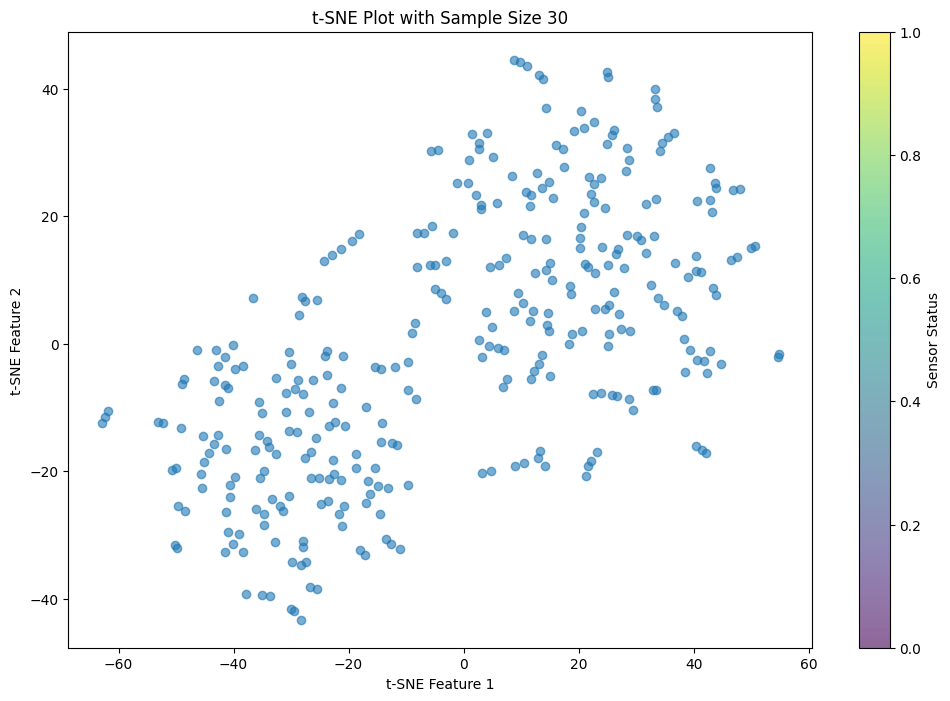

/tmp/ipykernel_7801/1886366813.py:194: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



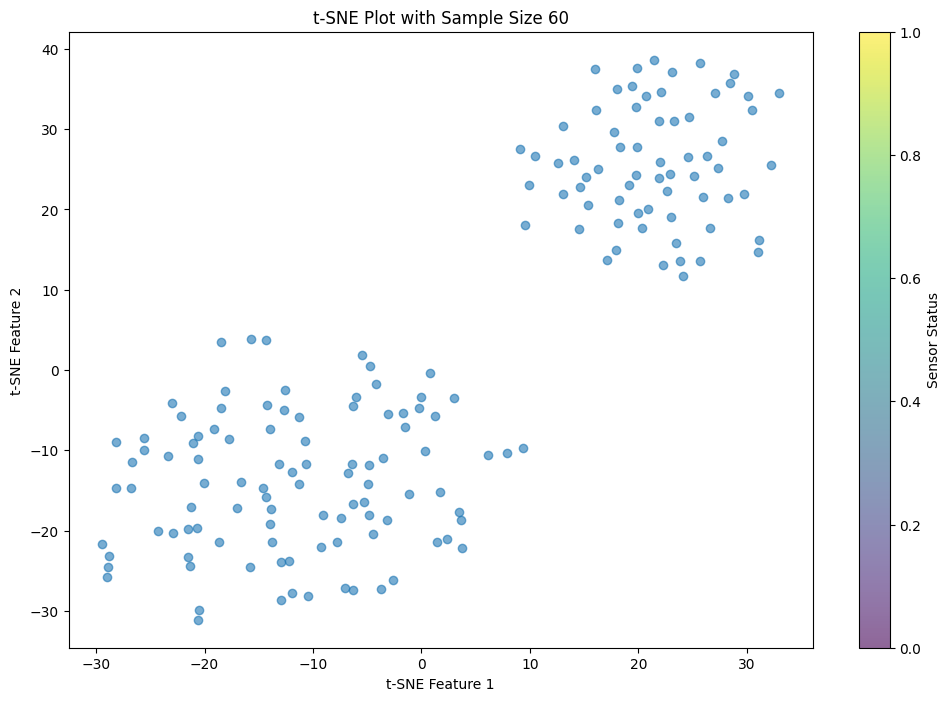

/tmp/ipykernel_7801/1886366813.py:194: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



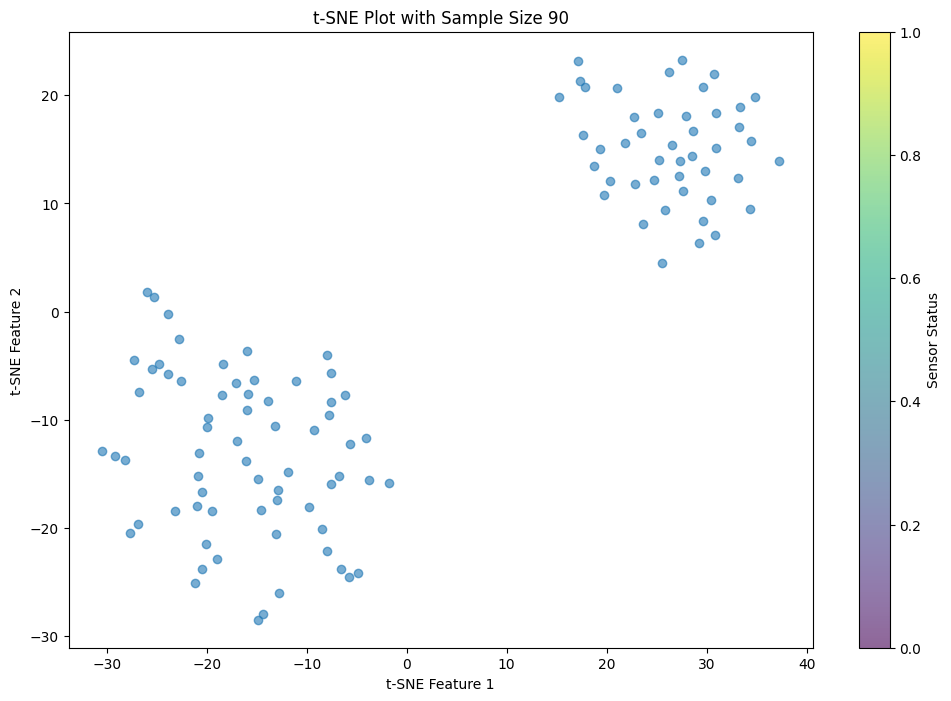

/tmp/ipykernel_7801/1886366813.py:194: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



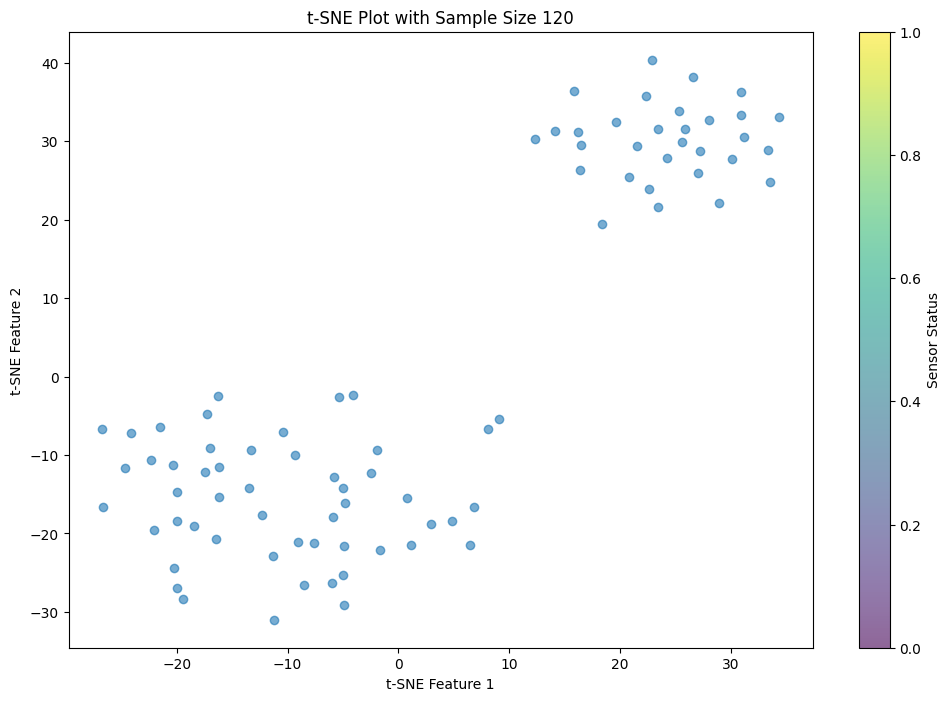

/tmp/ipykernel_7801/1886366813.py:194: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



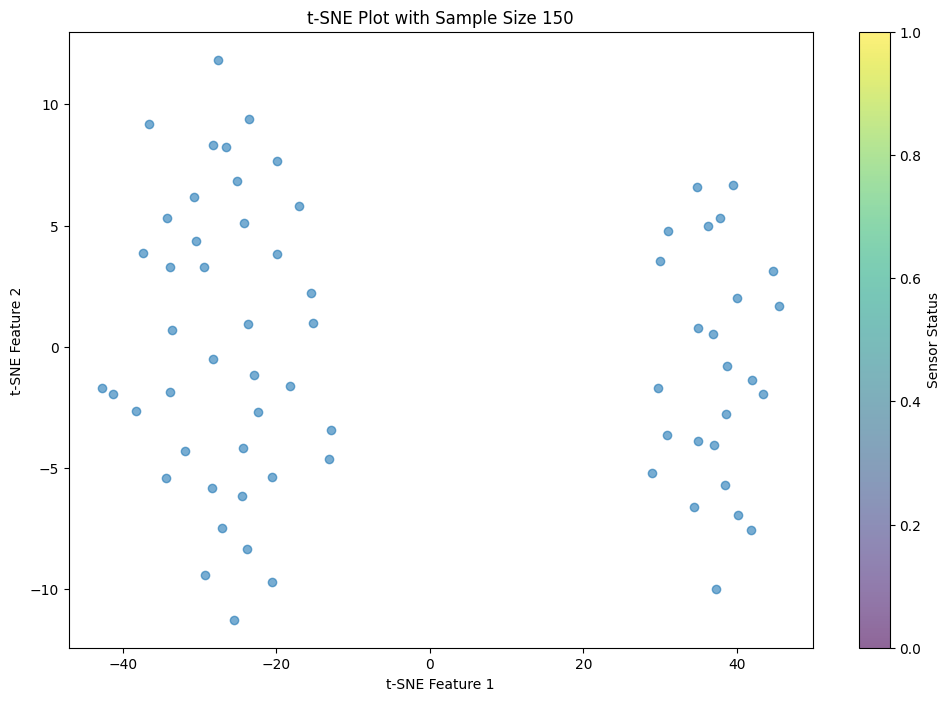

/tmp/ipykernel_7801/1886366813.py:194: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



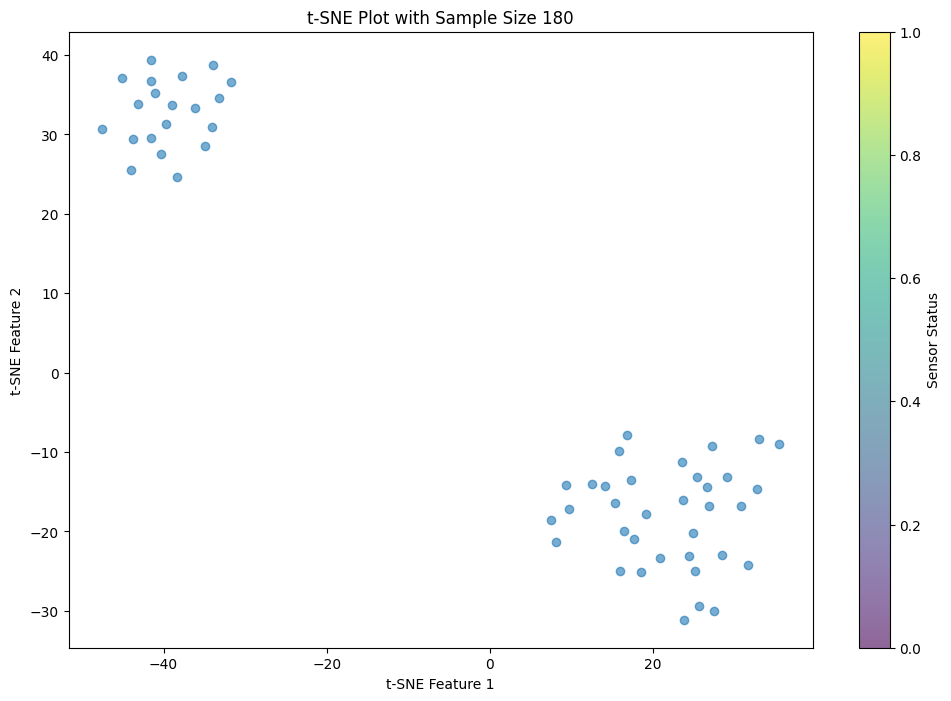

In [30]:
data = '/home/hubble/work/serenade/data/subject_3/environmentals/Printer.csv'
df = pd.read_csv(data)
df = df[:10000]


for size in [30, 60, 90, 120, 150, 180]:# 210, 240, 270, 300]:
    plot_tsne(size, df)

/tmp/ipykernel_7801/1886366813.py:194: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



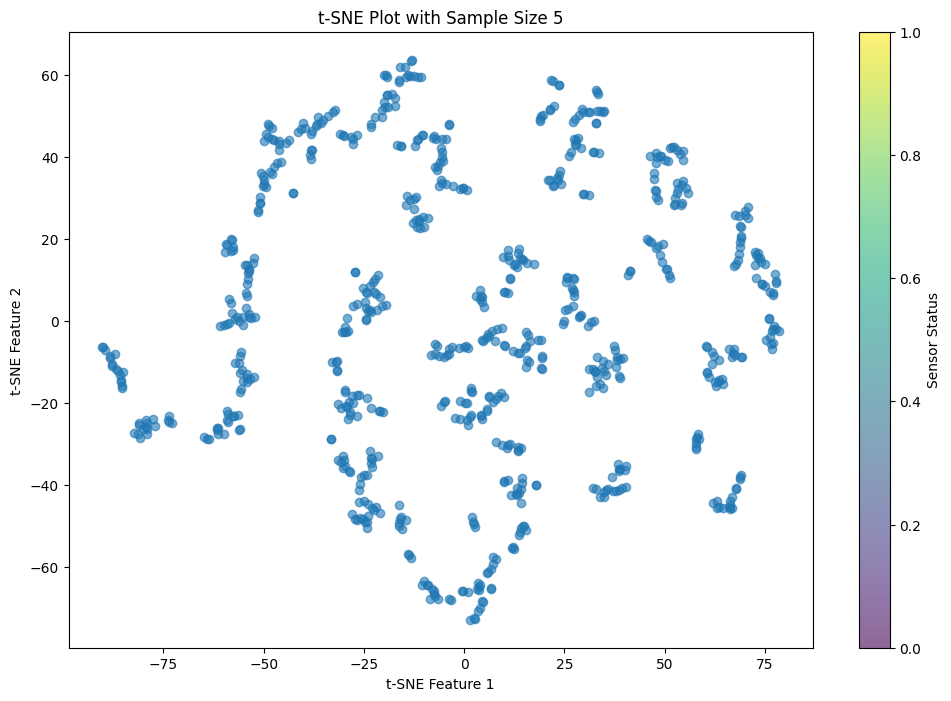

/tmp/ipykernel_7801/1886366813.py:194: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



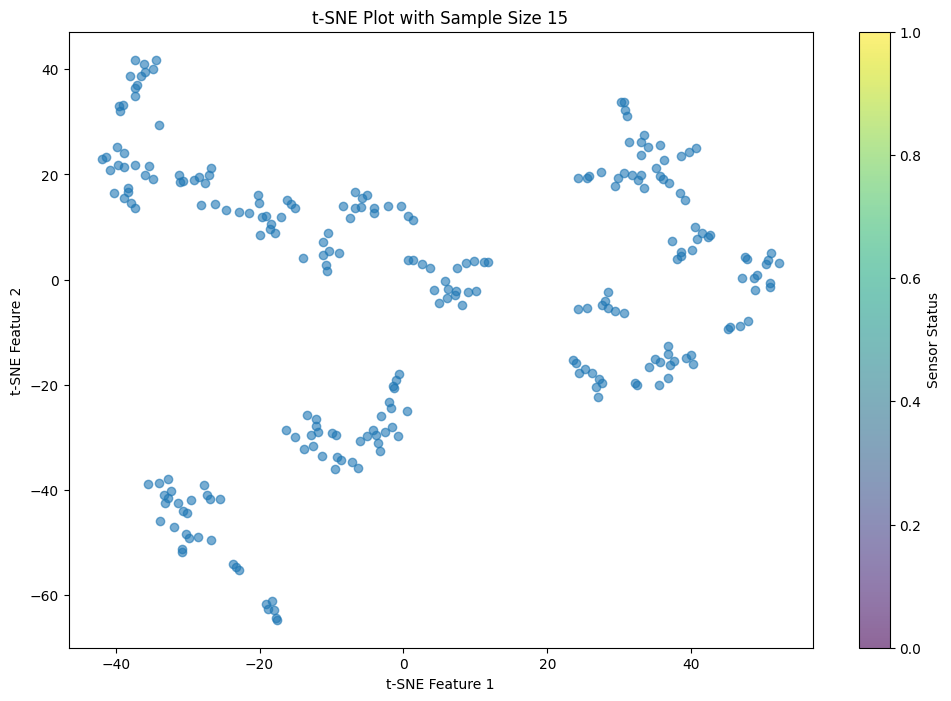

/tmp/ipykernel_7801/1886366813.py:194: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



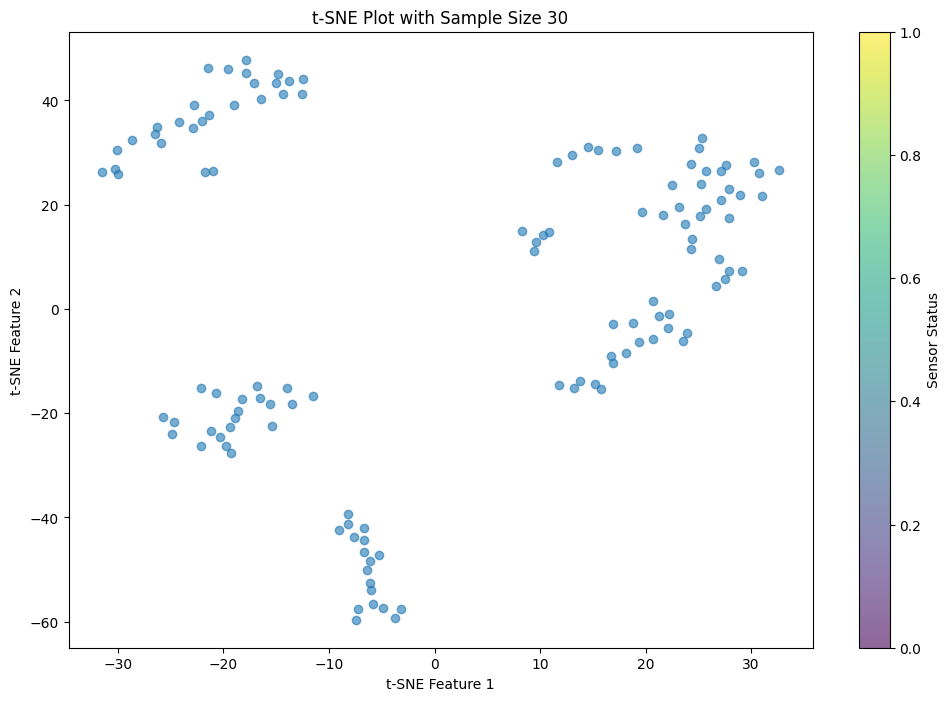

/tmp/ipykernel_7801/1886366813.py:194: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



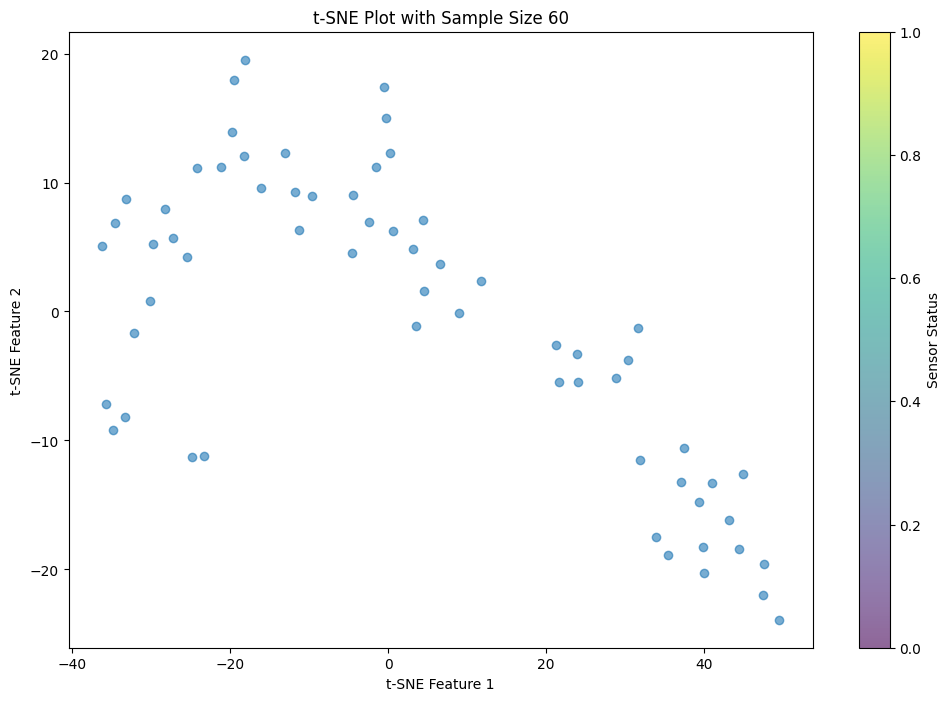

/tmp/ipykernel_7801/1886366813.py:194: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



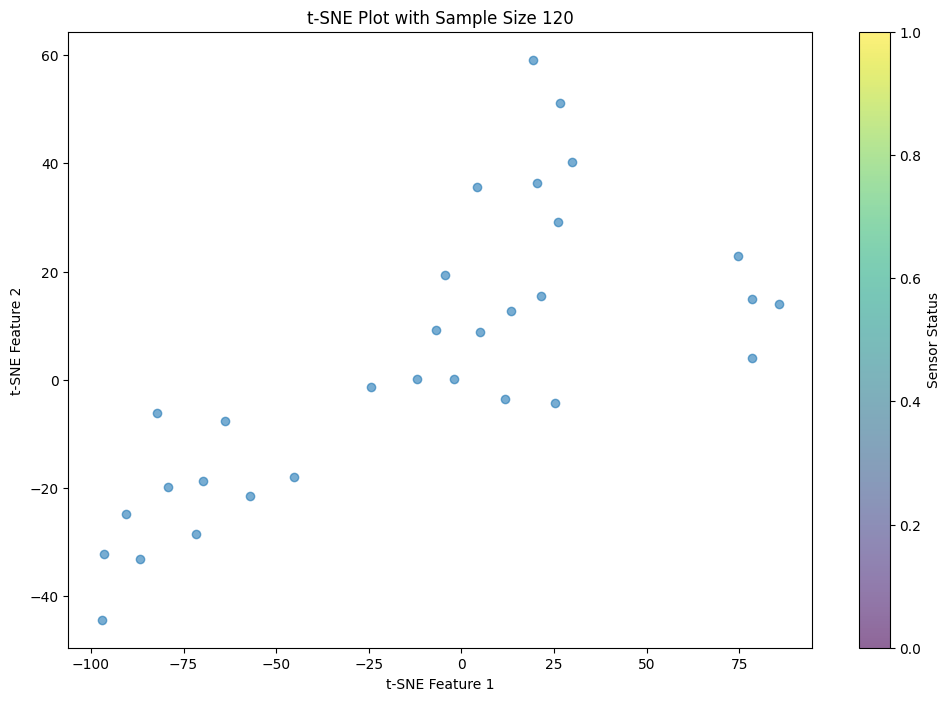

/tmp/ipykernel_7801/1886366813.py:194: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



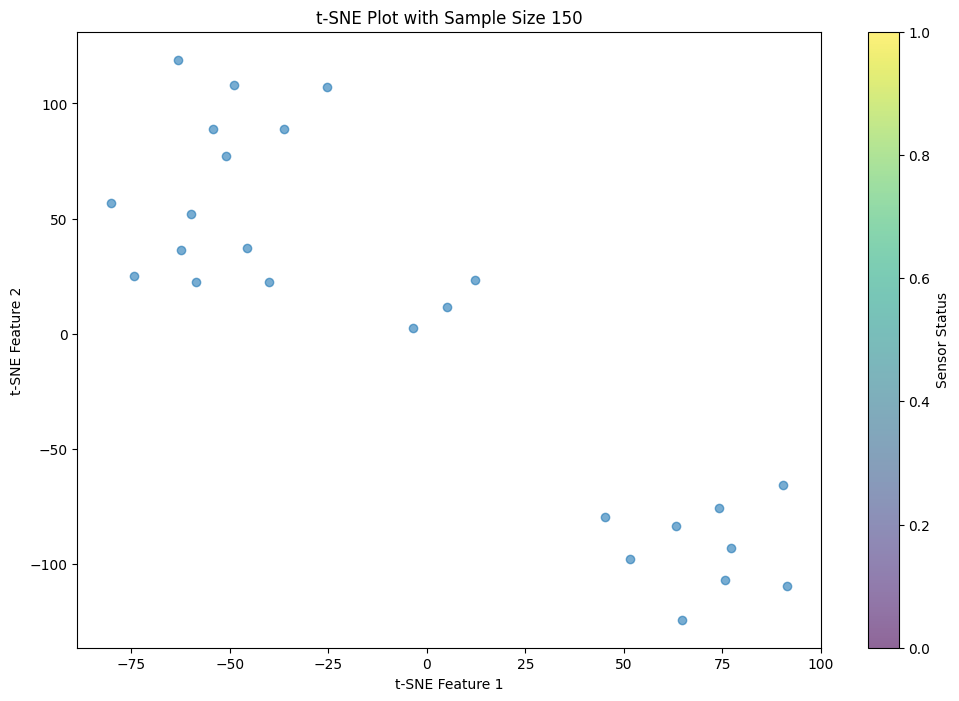

/tmp/ipykernel_7801/1886366813.py:194: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



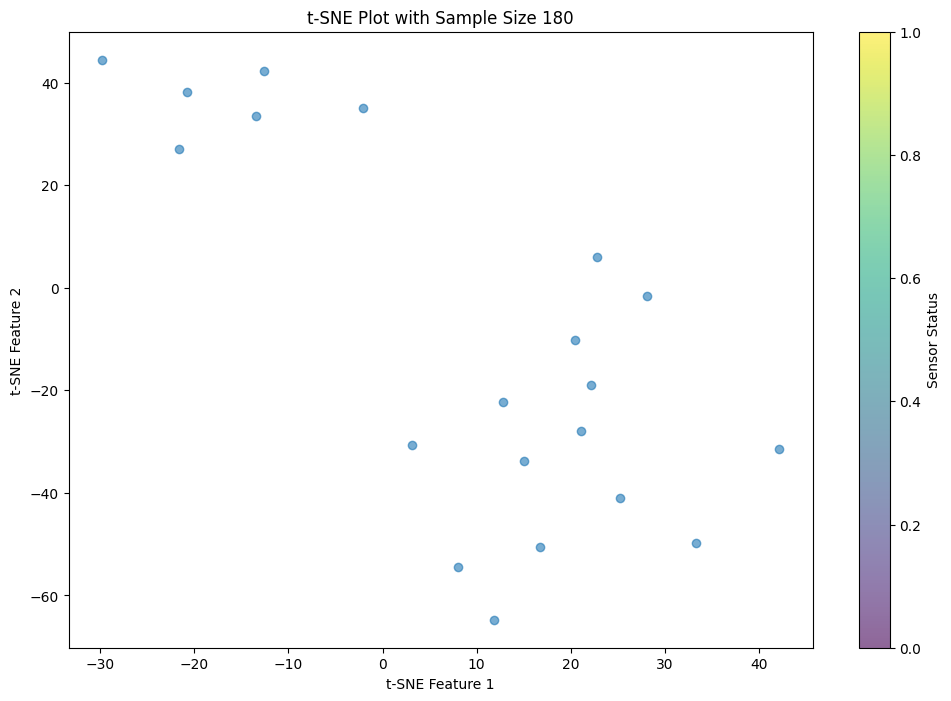

/tmp/ipykernel_7801/1886366813.py:194: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



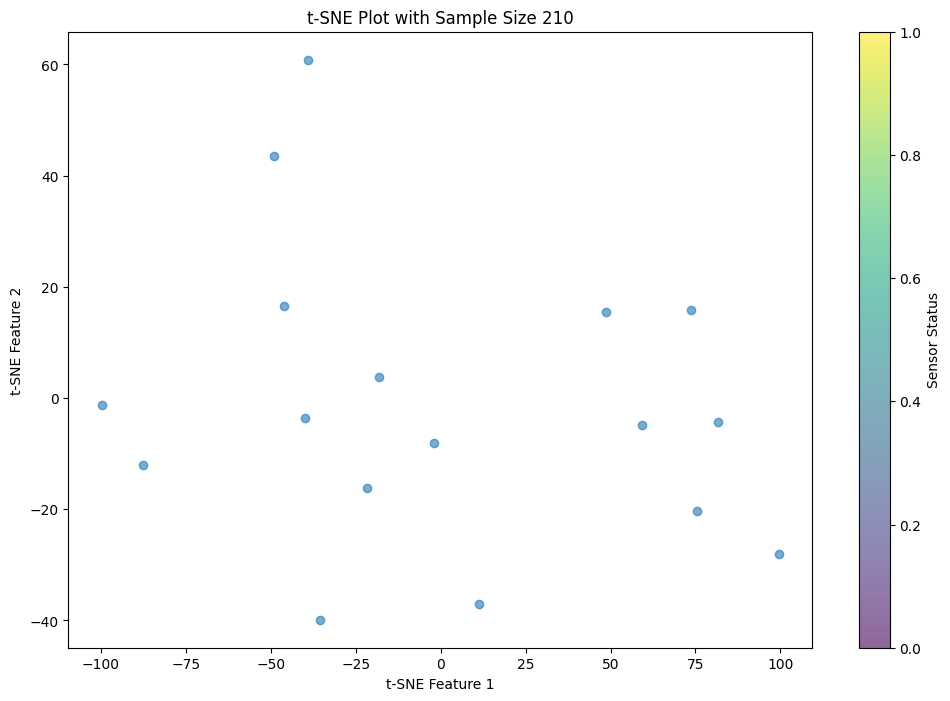

/tmp/ipykernel_7801/1886366813.py:194: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



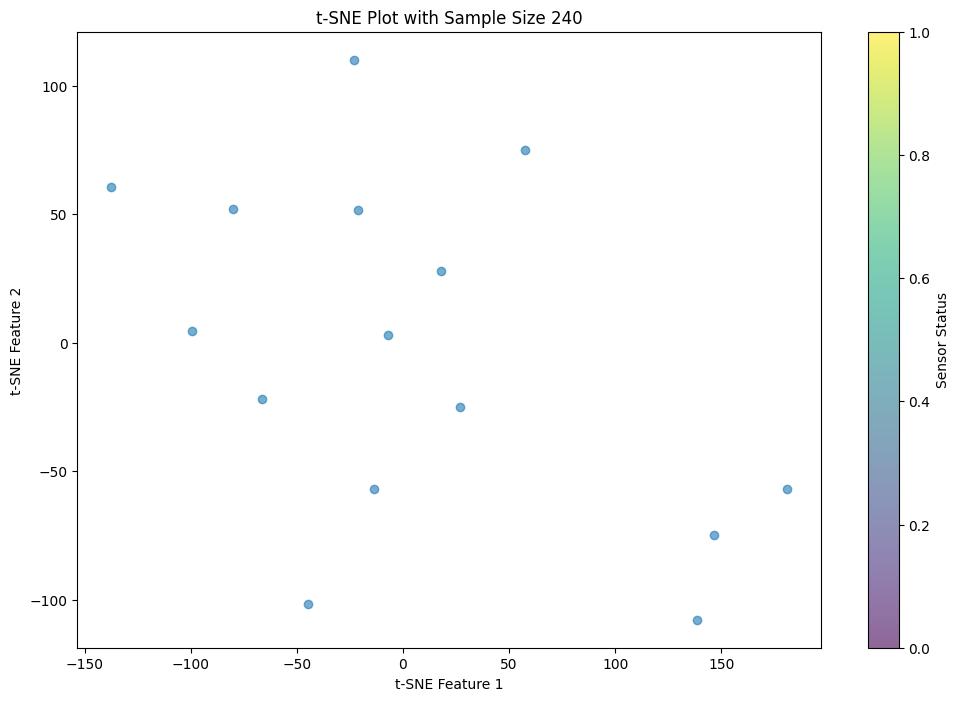

/tmp/ipykernel_7801/1886366813.py:194: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



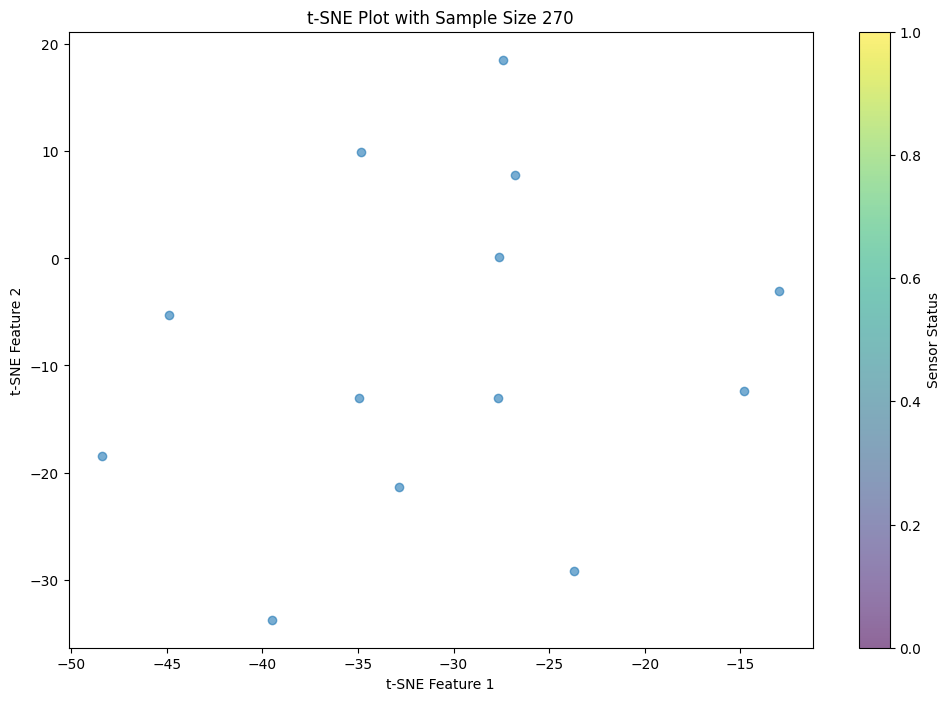

/tmp/ipykernel_7801/1886366813.py:194: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



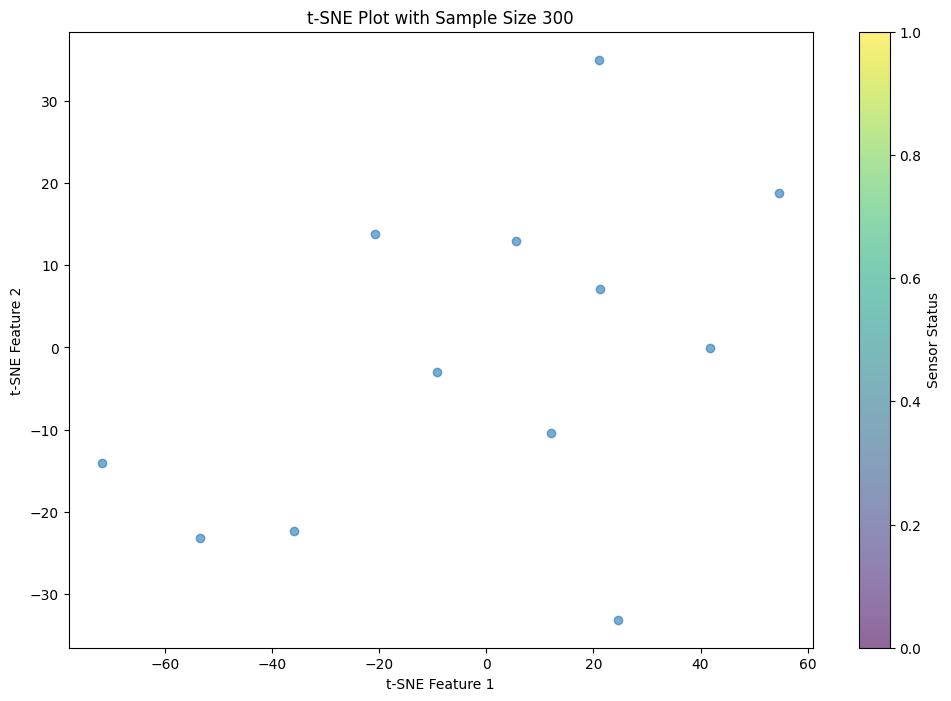

In [27]:
data =pd.read_csv('/home/hubble/work/serenade/data/subject_3/environmentals/Shower_Hum_Temp_humidity.csv')
df = pd.DataFrame(data)
for size in [5, 15,]:#  30, 60, 120, 150, 180, 210, 240, 270, 300]:
    plot_tsne(size, df)

In [ ]:
# path_subject_3 = '/home/hubble/work/serenade/data/subject_3/environmentals/'
# skip_substrings = ['event', 'houseentrance']
# formatted_sensors_data = []
# sensors_data = sorted(os.listdir(path_subject_3))
# for i in range(len(sensors_data)):
#     sensor_name = sensors_data[i].lower()
#     if any(substring in sensor_name for substring in skip_substrings):
#         print(sensor_name, '----XXXX')
#         continue
#     else:
#         # read the csv file and remove bad values
#         # format it correctly
#         df_cleaned, arr_cleaned = remove_unknown_unavailable(os.path.join(path_subject_3,sensors_data[i]))
#         print(sensor_name)
#         print(df_cleaned)
#         df_processed = process_sensor_data(df_cleaned)  
#         formatted_sensors_data.append({'sensor_name':sensor_name, 'df_processed':df_processed})
#         print('-------------------')